# Проект: промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 
Заказчик хочет использовать разработанную модель для имитации технологического процесса. Ниже расскажем о деталях этого процесса. Их важно знать, прежде чем генерировать новые признаки.

**Цель проекта:**

Оптимизировать производственные расходы металлургического комбината с помощью построения модели машинного обучения, которая предсказывает температуру сплава. Модель позволит снизить затраты на электричество, обслуживание и ремонты.

- Целевая переменная target - последняя температура по всей партии 
- Целевая метрика - MAE (нужно получить не более 6.8 на тесте)

**Описание этапа обработки:**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).


**Описание данных:**

Данные состоят из нескольких файлов, полученных из разных источников:
    
- data_arc_new.csv — данные об электродах

- data_bulk_new.csv — данные о подаче сыпучих материалов (объём)

- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время)

- data_wire_new.csv — данные о проволочных материалах (объём)

- data_wire_time_new.csv — данные о проволочных материалах (время)

- data_gas_new.csv — данные о продувке сплава газом

- data_temp_new.csv — результаты измерения температуры

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key, они соответствуют разным итерациям обработки.

**План работы:**

1. Загрузка данных
2. Исследовательский анализ и предобработка данных
3. Объединение данных
4. Исследовательский анализ и предобработка данных объединённого датафрейма
5. Подготовка данных
6. Обучение моделей машинного обучения и выбор лучшей модели
7. Общий вывод и рекомендации заказчику

# 1. Загрузка данных

## 1.1.Импорт библиотек

In [1]:
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import missingno as msno
except:
    !pip install missingno -q
    import missingno as msno
    
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
pd.set_option('display.max_columns', None)

In [2]:
RANDOM_STATE = 141024

## 1.2. Осмотр данных

In [3]:
def file_download(file_name):
    pth_1 = f'/datasets/{file_name}'
    pth_2 = f'https://code.s3.yandex.net/datasets/{file_name}'
    if os.path.exists(pth_1):
        data = pd.read_csv(pth_1)
    else:
        data = pd.read_csv(pth_2)
    print(f'Размерность таблицы {data.shape}') 
    return data

### 1.2.1. Файл data_arc_new.csv — данные об электродах

- key — номер партии;
- Начало нагрева дугой — время начала нагрева;
- Конец нагрева дугой — время окончания нагрева;
- Активная мощность — значение активной мощности;
- Реактивная мощность — значение реактивной мощности.

In [4]:
data_arc = file_download('data_arc_new.csv')
data_arc.head()

Размерность таблицы (14876, 5)


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


### 1.2.2. Файл data_bulk_new.csv - данные о подаче сыпучих материалов (объём)

- key — номер партии;
- Bulk 1 … Bulk 15 — объём подаваемого материала.

In [5]:
data_bulk = file_download('data_bulk_new.csv')
data_bulk.head()

Размерность таблицы (3129, 16)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


### 1.2.3. Файл data_bulk_time_new.csv - данные о подаче сыпучих материалов (время)

- key — номер партии;
- Bulk 1 … Bulk 15 — время подачи материала.

In [6]:
data_bulk_time = file_download('data_bulk_time_new.csv')
data_bulk_time.head()

Размерность таблицы (3129, 16)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


### 1.2.4. Файл data_gas_new.csv — данные о продувке сплава газом

- key — номер партии;
- Газ 1 — объём подаваемого газа.

In [7]:
data_gas = file_download('data_gas_new.csv')
data_gas.head()

Размерность таблицы (3239, 2)


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


### 1.2.5. Файл data_temp_new.csv — результаты измерения температуры

- key — номер партии;
- Время замера — время замера;
- Температура — значение температуры.

In [8]:
data_temp = file_download('data_temp_new.csv')
data_temp.head()

Размерность таблицы (18092, 3)


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


### 1.2.6. Файл data_wire_new.csv — данные о проволочных материалах (объём)

- key — номер партии;
- Wire 1 … Wire 9 — объём подаваемых проволочных материалов.

In [9]:
data_wire = file_download('data_wire_new.csv')
data_wire.head()

Размерность таблицы (3081, 10)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.2.7. Файл data_wire_time_new.csv — данные о проволочных материалах (время)

- key — номер партии;
- Wire 1 … Wire 9 — время подачи проволочных материалов.

In [10]:
data_wire_time = file_download('data_wire_time_new.csv')
data_wire_time.head()

Размерность таблицы (3081, 10)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1.3. Вывод по загрузке данных

1. Представленные заказчиком данные загружены и соответствуют описанию
2. Названия столбцов не соответствуют требованиям
3. Типы данных в части столбцов не соответствуют содержанию
4. Данные имеют разные размерности

# 2. Исследовательский анализ и предобработка данных

## 2.1. Файл data_arc_new.csv — данные об электродах

Описательная статистика:


,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876,14876,14876.00,14876.00
unique,14876,14876,NaN,NaN
top,2019-05-03 11:02:14,2019-05-03 11:06:02,NaN,NaN
freq,1,1,NaN,NaN
mean,NaN,NaN,0.66,0.44
std,NaN,NaN,0.26,5.87
min,NaN,NaN,0.22,-715.48
25%,NaN,NaN,0.47,0.34
50%,NaN,NaN,0.60,0.44
75%,NaN,NaN,0.83,0.61


-----
Информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

-----
Процент наличия данных:



key                     100.0
Начало нагрева дугой    100.0
Конец нагрева дугой     100.0
Активная мощность       100.0
Реактивная мощность     100.0
dtype: float64

-----
Количество явных дубликатов:0
-----
Матрица пропущенных значений:


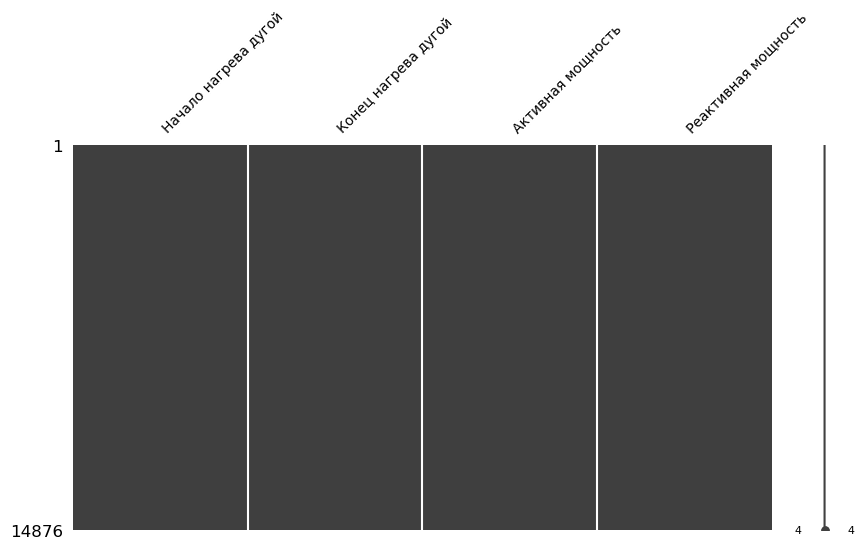

In [11]:
def res_analysis(data):
    print('Описательная статистика:')
    display(data.iloc[:,1:].describe(include=['object', 'float', 'int']).round(2))
    print('-----\nИнформация:\n')
    display(data.info())
    print('-----\nПроцент наличия данных:\n')
    display(100 - (data.isna().sum() / data.shape[0] * 100.00))
    print(f'-----\nКоличество явных дубликатов:{data.duplicated().sum()}')
    print('-----\nМатрица пропущенных значений:')
    msno.matrix(data.iloc[:,1:], figsize=(10, 5), fontsize=10);
    
res_analysis(data_arc)

Переименовывание столбцов и преобразование формата даты.

In [12]:
data_arc = data_arc.rename(
    columns={
        'Начало нагрева дугой':'start_heating',
        'Конец нагрева дугой': 'finish_heating',
        'Активная мощность': 'active_power',
        'Реактивная мощность': 'reactive_power',
    }
)
data_arc['start_heating'] = pd.to_datetime(data_arc['start_heating'], format='%Y-%m-%d %H:%M:%S')
data_arc['finish_heating'] = pd.to_datetime(data_arc['finish_heating'], format='%Y-%m-%d %H:%M:%S')
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   start_heating   14876 non-null  datetime64[ns]
 2   finish_heating  14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Имеется выброс с отрицательным значением реактивной мощности, можно поменять значение на медианное. Хотя при количестве строк 14876 можно и удалить строку, т.к. на качество предсказания это не сильно повлияет.

In [13]:
data_arc.query('reactive_power < 0')

,key,start_heating,finish_heating,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [14]:
data_arc.query('key == 2116')

,key,start_heating,finish_heating,active_power,reactive_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


In [15]:
data_arc = data_arc.query('key != 2116')
data_arc.shape

(14872, 5)

Построение гистограммы данных и Boxplot.

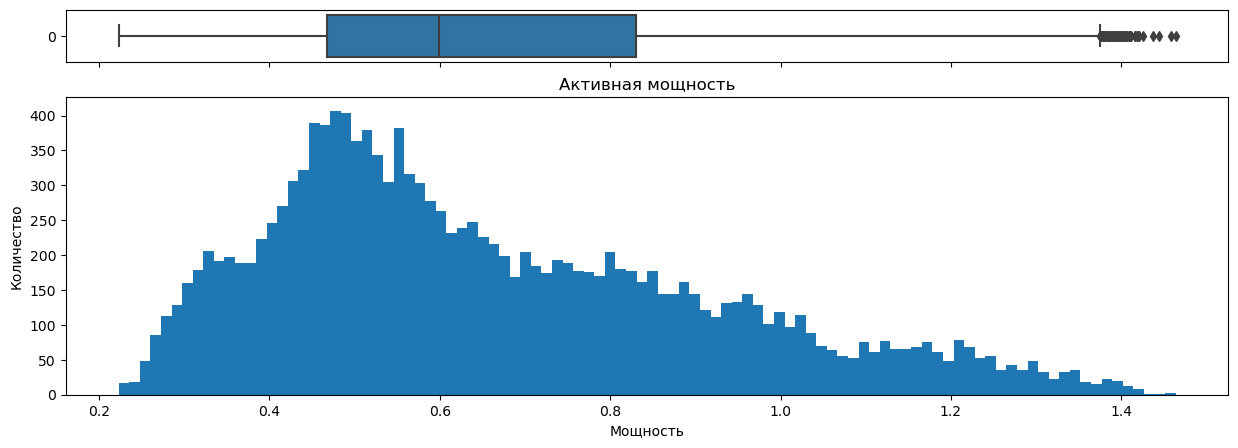

In [16]:
def hist_box(data, bins, title, xlabel, ylabel):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(15,5), gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(data=[data], orient="h", ax=ax_box)
    plt.hist(data, bins=bins, range=(data.min(),data.max()))
 
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show();
    
hist_box(
    data=data_arc['active_power'],
    bins=100, 
    title='Активная мощность',
    xlabel='Мощность',
    ylabel='Количество'
)

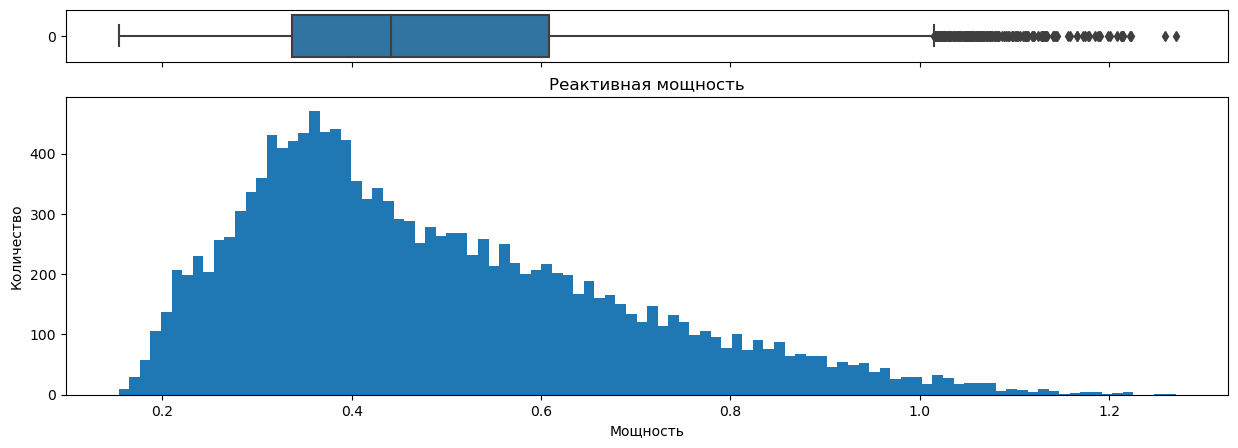

In [17]:
hist_box(
    data=data_arc['reactive_power'],
    bins=100, 
    title='Реактивная мощность',
    xlabel='Мощность',
    ylabel='Количество'
)

Дополнительные переменные:
- Полная мощность P = (A^2+R^2)^0.5
- Расчет времени нагрева в секундах T
- Полная энергия E = P * T

In [18]:
data_arc['full_power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2)**0.5
data_arc['heating_time'] = (data_arc['finish_heating'] - data_arc['start_heating']).dt.seconds
data_arc['full_energy'] = data_arc['full_power'] * data_arc['heating_time']
data_arc.head()

,key,start_heating,finish_heating,active_power,reactive_power,full_power,heating_time,full_energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148,159.830252


Объединение данных по номеру партии, расчет количества циклов нагрева.

In [19]:
data_arc = data_arc.pivot_table(index='key',
                                values=['active_power',
                                        'reactive_power',
                                        'full_power',
                                        'heating_time',
                                        'full_energy',
                                        'start_heating'
                                       ],
                                aggfunc={'active_power': 'sum',
                                         'reactive_power': 'sum',
                                         'full_power': 'sum',
                                         'heating_time': 'sum',
                                         'full_energy': 'sum',
                                         'start_heating' : 'count'
                                        }).reset_index().rename(columns={'start_heating':'number_of_heating'}
)
data_arc.columns

Index(['key', 'active_power', 'full_energy', 'full_power', 'heating_time',
       'reactive_power', 'number_of_heating'],
      dtype='object')

In [20]:
data_arc = data_arc[['key',
                     'active_power',
                     'reactive_power',
                     'full_power',
                     'heating_time',
                     'full_energy',
                     'number_of_heating'
                    ]]
display(data_arc.shape)
data_arc.head()

(3213, 7)

,key,active_power,reactive_power,full_power,heating_time,full_energy,number_of_heating
0,1,3.036730,2.142821,3.718736,1098,770.282114,5
1,2,2.139408,1.453357,2.588349,811,481.760005,4
2,3,4.063641,2.937457,5.019223,655,722.837668,5
3,4,2.706489,2.056992,3.400038,741,683.455597,4
4,5,2.252950,1.687991,2.816980,869,512.169934,4


Построение гистограммы данных и Boxplot.

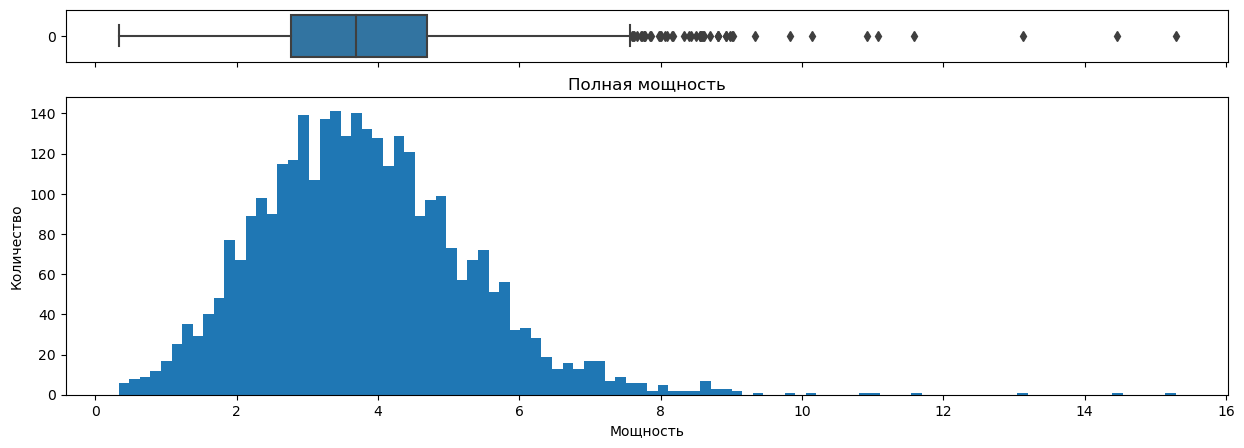

In [21]:
hist_box(
    data=data_arc['full_power'],
    bins=100, 
    title='Полная мощность',
    xlabel='Мощность',
    ylabel='Количество'
)

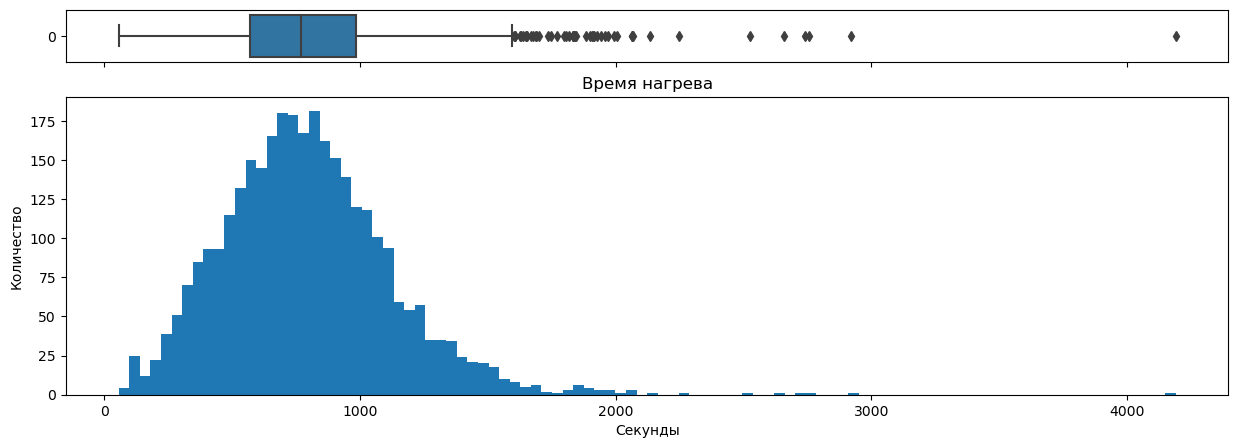

In [22]:
hist_box(
    data=data_arc['heating_time'],
    bins=100, 
    title='Время нагрева',
    xlabel='Секунды',
    ylabel='Количество'
)

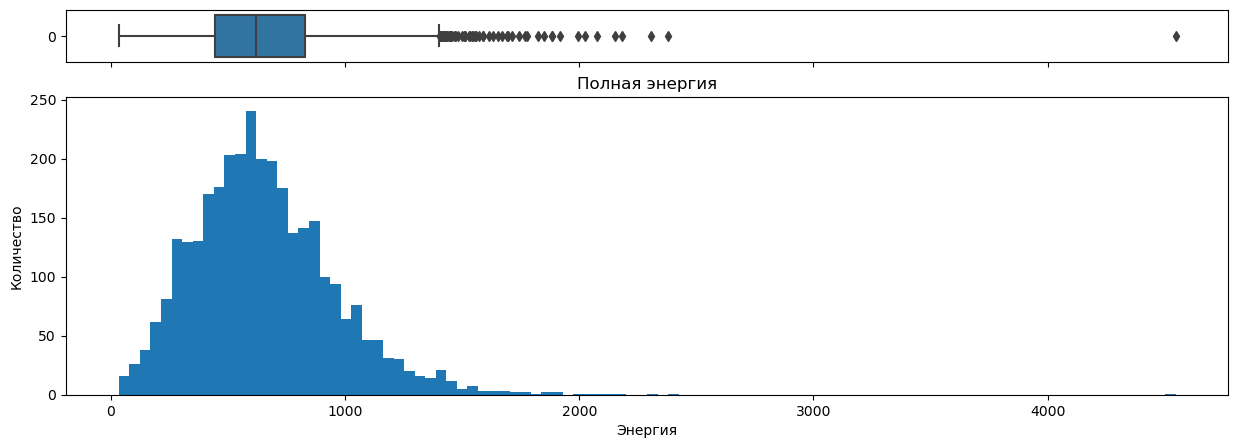

In [23]:
hist_box(
    data=data_arc['full_energy'],
    bins=100, 
    title='Полная энергия',
    xlabel='Энергия',
    ylabel='Количество'
)

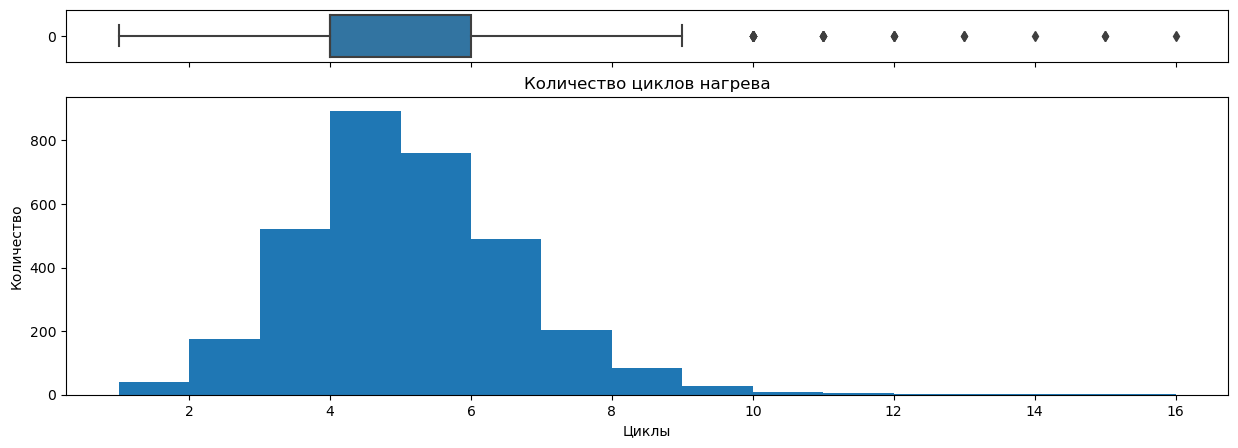

In [24]:
hist_box(
    data=data_arc['number_of_heating'],
    bins=15, 
    title='Количество циклов нагрева',
    xlabel='Циклы',
    ylabel='Количество'
)

## 2.2. Файл data_bulk_new.csv - данные о подаче сыпучих материалов (объём)

Описательная статистика:


,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252.00,22.00,1298.00,1014.00,77.00,576.00,25.00,1.0,19.00,176.00,177.00,2450.00,18.00,2806.00,2248.00
mean,39.24,253.05,113.88,104.39,107.03,118.93,305.60,49.0,76.32,83.28,76.82,260.47,181.11,170.28,160.51
std,18.28,21.18,75.48,48.18,81.79,72.06,191.02,NaN,21.72,26.06,59.66,120.65,46.09,65.87,51.77
min,10.00,228.00,6.00,12.00,11.00,17.00,47.00,49.0,63.00,24.00,8.00,53.00,151.00,16.00,1.00
25%,27.00,242.00,58.00,72.00,70.00,69.75,155.00,49.0,66.00,64.00,25.00,204.00,153.25,119.00,105.00
50%,31.00,251.50,97.50,102.00,86.00,100.00,298.00,49.0,68.00,86.50,64.00,208.00,155.50,151.00,160.00
75%,46.00,257.75,152.00,133.00,132.00,157.00,406.00,49.0,70.50,102.00,106.00,316.00,203.50,205.75,205.00
max,185.00,325.00,454.00,281.00,603.00,503.00,772.00,49.0,147.00,159.00,313.00,1849.00,305.00,636.00,405.00


-----
Информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


None

-----
Процент наличия данных:



key        100.000000
Bulk 1       8.053691
Bulk 2       0.703100
Bulk 3      41.482902
Bulk 4      32.406520
Bulk 5       2.460850
Bulk 6      18.408437
Bulk 7       0.798977
Bulk 8       0.031959
Bulk 9       0.607223
Bulk 10      5.624800
Bulk 11      5.656759
Bulk 12     78.299776
Bulk 13      0.575264
Bulk 14     89.677213
Bulk 15     71.844040
dtype: float64

-----
Количество явных дубликатов:0
-----
Матрица пропущенных значений:


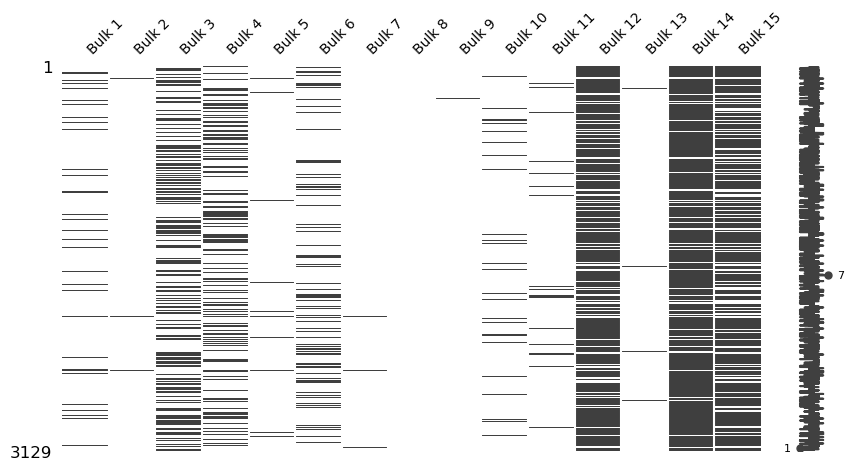

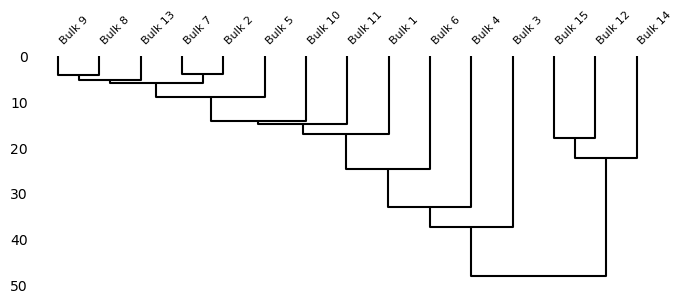

In [25]:
res_analysis(data_bulk)
msno.dendrogram(data_bulk.iloc[:,1:], figsize=(8, 3), fontsize=8);

Переименование столбцов.

In [26]:
data_bulk.columns = data_bulk.columns.str.lower().str.replace(' ', '_')
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


Удаление признаков с количеством пропусков больше 80 %, заполнение пропусков 0.

In [27]:
data_bulk = data_bulk[['key', 'bulk_12','bulk_14']]
data_bulk = data_bulk.fillna(0)
print(f'Количество пропусков в таблице:\n{data_bulk.isna().sum()}')

Количество пропусков в таблице:
key        0
bulk_12    0
bulk_14    0
dtype: int64


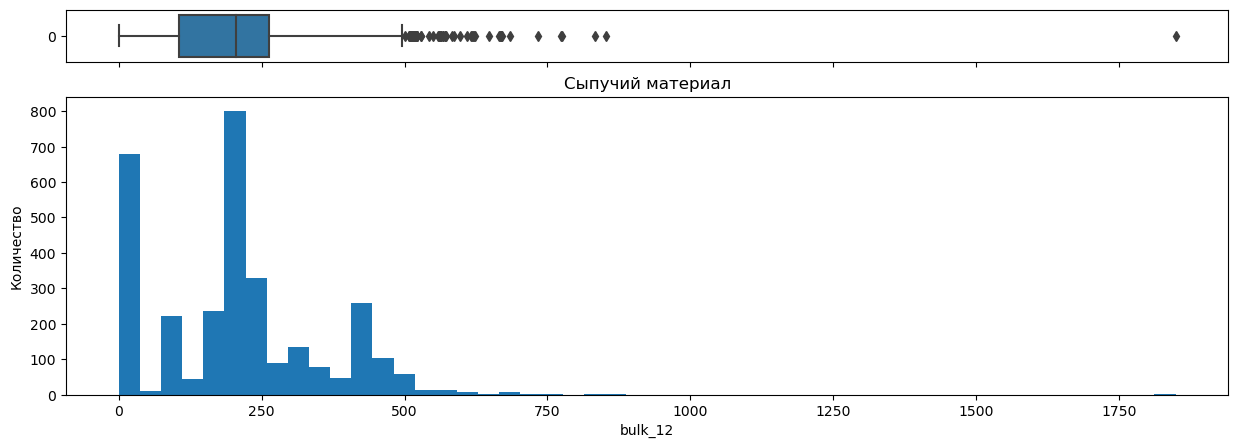

In [28]:
hist_box(
    data=data_bulk['bulk_12'],
    bins=50, 
    title='Сыпучий материал',
    xlabel='bulk_12',
    ylabel='Количество'
)

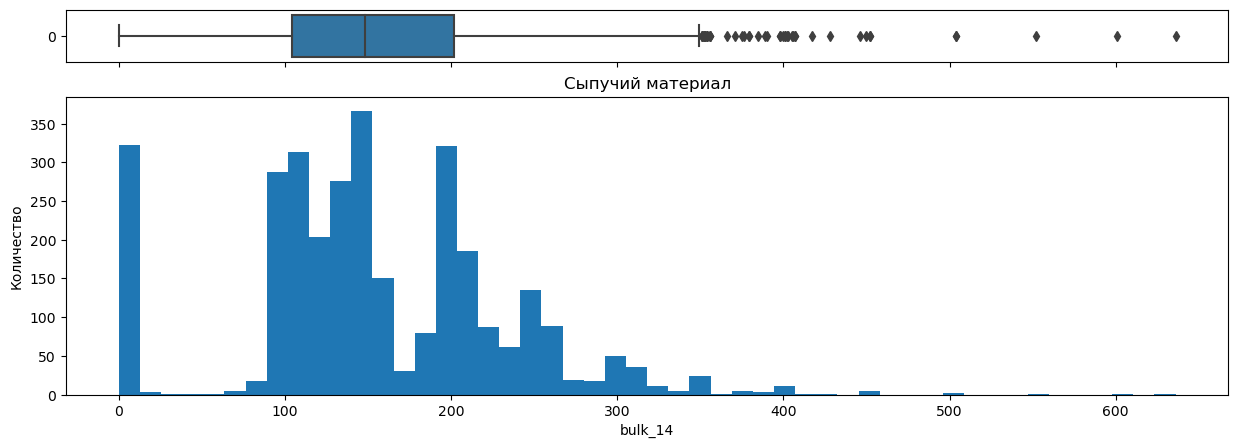

In [29]:
hist_box(
    data=data_bulk['bulk_14'],
    bins=50, 
    title='Сыпучий материал',
    xlabel='bulk_14',
    ylabel='Количество'
)

## 2.3. Файл data_bulk_time_new.csv - данные о подаче сыпучих материалов (время)

Описательная статистика:


,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
unique,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
top,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43
freq,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


-----
Информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


None

-----
Процент наличия данных:



key        100.000000
Bulk 1       8.053691
Bulk 2       0.703100
Bulk 3      41.482902
Bulk 4      32.406520
Bulk 5       2.460850
Bulk 6      18.408437
Bulk 7       0.798977
Bulk 8       0.031959
Bulk 9       0.607223
Bulk 10      5.624800
Bulk 11      5.656759
Bulk 12     78.299776
Bulk 13      0.575264
Bulk 14     89.677213
Bulk 15     71.844040
dtype: float64

-----
Количество явных дубликатов:0
-----
Матрица пропущенных значений:


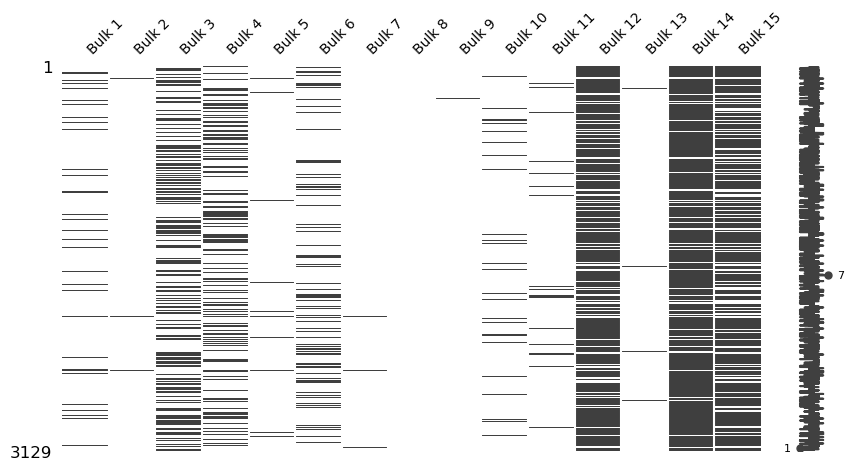

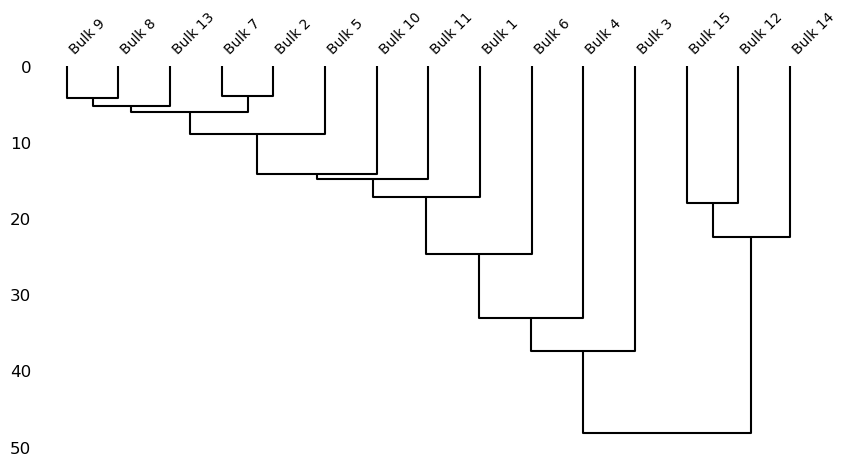

In [30]:
res_analysis(data_bulk_time)
msno.dendrogram(data_bulk_time.iloc[:,1:], figsize=(10, 5), fontsize=10);

Конечная температура расплава не зависит от времени засыпки сыпучих материалов, поэтому исключим эти данные из обучения модели.

## 2.4. Файл data_gas_new.csv — данные о продувке сплава газом

Описательная статистика:


,Газ 1
count,3239.00
mean,11.00
std,6.22
min,0.01
25%,7.04
50%,9.84
75%,13.77
max,78.00


-----
Информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

-----
Процент наличия данных:



key      100.0
Газ 1    100.0
dtype: float64

-----
Количество явных дубликатов:0
-----
Матрица пропущенных значений:


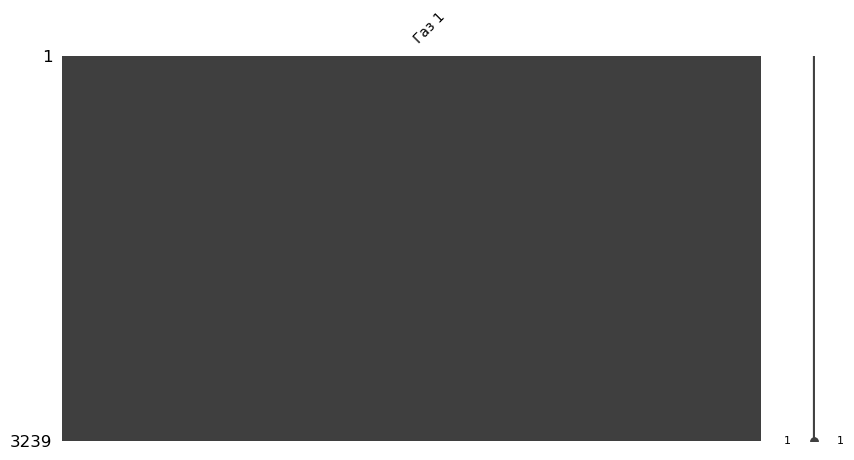

In [31]:
res_analysis(data_gas)

Переименование столбцов.

In [32]:
data_gas = data_gas.rename(columns={'Газ 1':'gas_1'})
data_gas.head()

,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


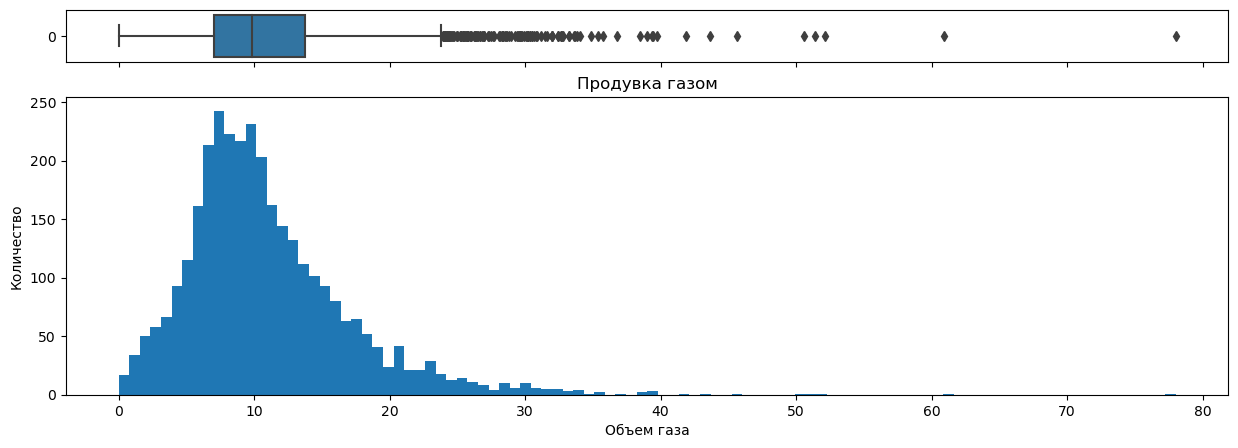

In [33]:
hist_box(
    data=data_gas['gas_1'],
    bins=100, 
    title='Продувка газом',
    xlabel='Объем газа',
    ylabel='Количество'
)

## 2.5. Файл data_temp_new.csv — результаты измерения температуры

Описательная статистика:


,Время замера,Температура
count,18092,14665.00
unique,18092,NaN
top,2019-05-03 11:02:04,NaN
freq,1,NaN
mean,NaN,1590.72
std,NaN,20.39
min,NaN,1191.00
25%,NaN,1580.00
50%,NaN,1590.00
75%,NaN,1599.00


-----
Информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

-----
Процент наличия данных:



key             100.000000
Время замера    100.000000
Температура      81.057926
dtype: float64

-----
Количество явных дубликатов:0
-----
Матрица пропущенных значений:


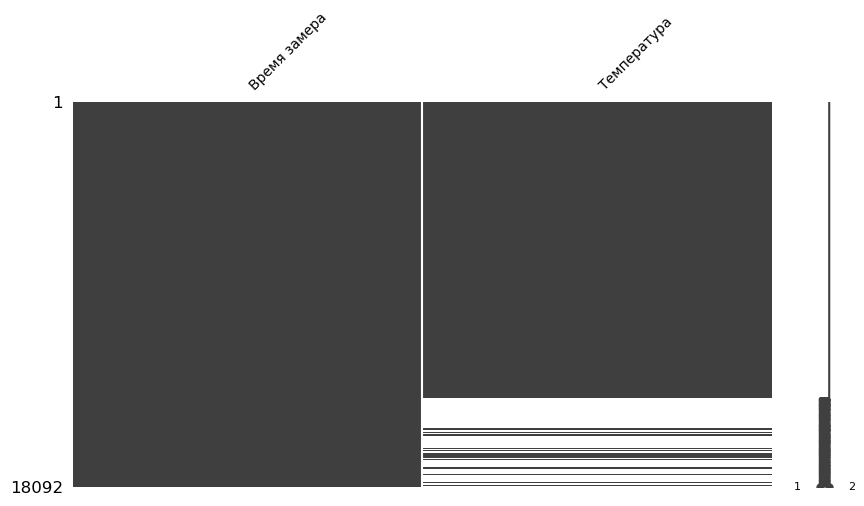

In [34]:
res_analysis(data_temp)

Переименование столцов и изменение формата времени.

In [35]:
data_temp = data_temp.rename(columns={'Время замера':'measuring_time',
                                      'Температура': 'temperature'
                                     }
)
data_temp['measuring_time'] = pd.to_datetime(data_temp['measuring_time'], format='%Y-%m-%d %H:%M:%S')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             18092 non-null  int64         
 1   measuring_time  18092 non-null  datetime64[ns]
 2   temperature     14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


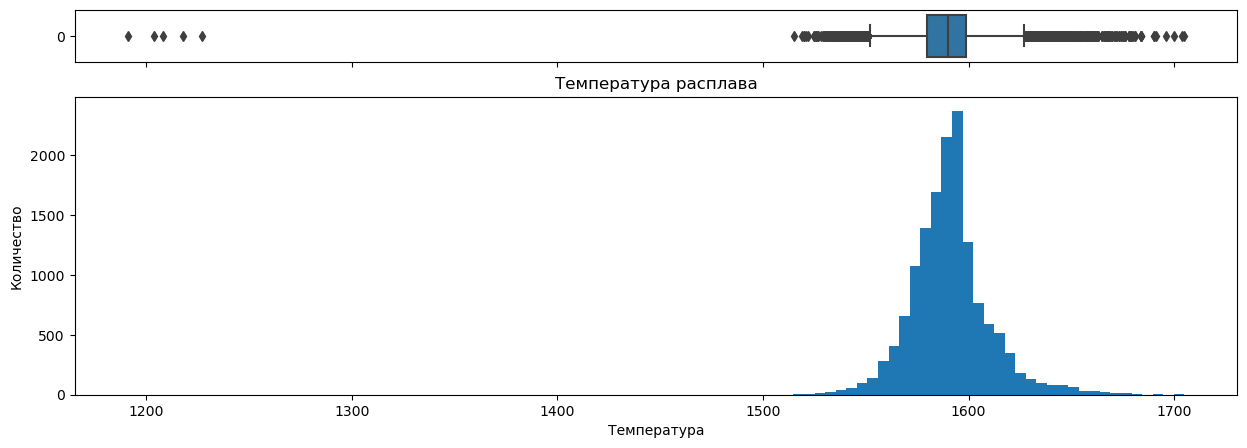

In [36]:
hist_box(
    data=data_temp['temperature'],
    bins=100, 
    title='Температура расплава',
    xlabel='Температура',
    ylabel='Количество'
)

Удаление расплавов с температурой ниже 1500.

In [37]:
data_temp = data_temp.dropna()
data_temp = data_temp.query('temperature > 1500')
keys = data_temp.pivot_table(index='key',
                                      values=['temperature'],
                                      aggfunc='count').query('temperature == 1').reset_index()
keys = keys['key'].tolist()
data_temp = data_temp.query('key not in @keys')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13920 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             13920 non-null  int64         
 1   measuring_time  13920 non-null  datetime64[ns]
 2   temperature     13920 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 435.0 KB


In [38]:
data_temp = data_temp.sort_values(
    by='measuring_time').pivot_table(
    index='key', values=['temperature'], aggfunc=['first', 'last']
).reset_index()
data_temp.columns = ['key', 'first_temperture', 'last_temperature']
data_temp.head()

,key,first_temperture,last_temperature
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


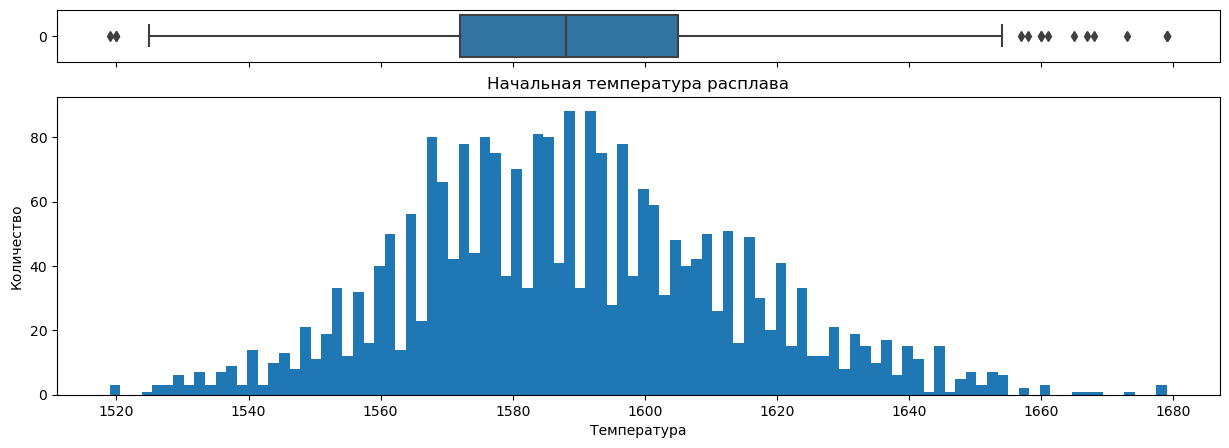

In [39]:
hist_box(
    data=data_temp['first_temperture'],
    bins=100, 
    title='Начальная температура расплава',
    xlabel='Температура',
    ylabel='Количество'
)

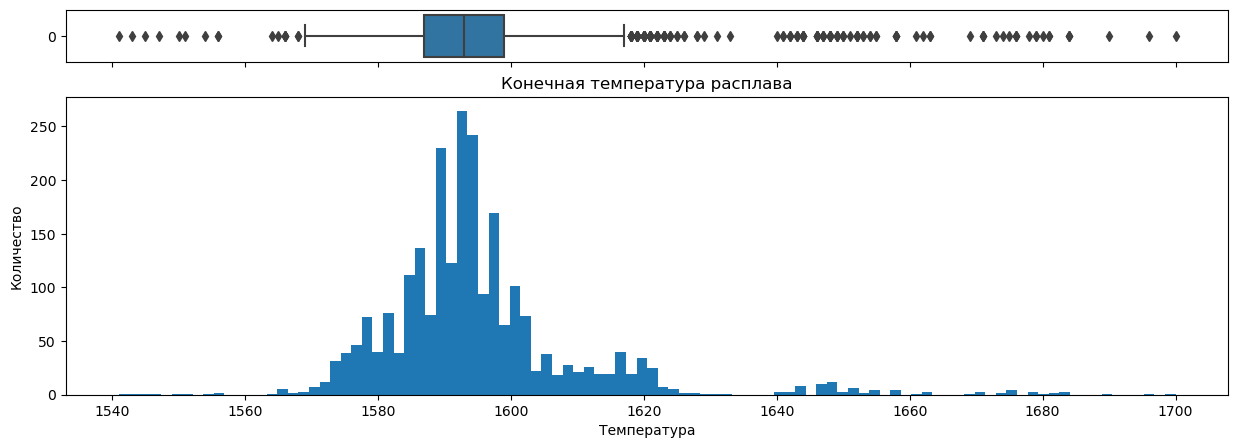

In [40]:
hist_box(
    data=data_temp['last_temperature'],
    bins=100, 
    title='Конечная температура расплава',
    xlabel='Температура',
    ylabel='Количество'
)

## 2.6. Файл data_wire_new.csv — данные о проволочных материалах (объём)

Описательная статистика:


,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3055.00,1079.00,63.00,14.00,1.00,73.00,11.00,19.00,29.00
mean,100.90,50.58,189.48,57.44,15.13,48.02,10.04,53.63,34.16
std,42.01,39.32,99.51,28.82,NaN,33.92,8.61,16.88,19.93
min,1.92,0.03,0.14,24.15,15.13,0.03,0.23,45.08,4.62
25%,72.12,20.19,95.14,40.81,15.13,25.05,6.76,46.09,22.06
50%,100.16,40.14,235.19,45.23,15.13,42.08,9.02,46.28,30.07
75%,126.06,70.23,276.25,76.12,15.13,64.21,11.89,48.09,43.86
max,330.31,282.78,385.01,113.23,15.13,180.45,32.85,102.76,90.05


-----
Информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

-----
Процент наличия данных:



key       100.000000
Wire 1     99.156118
Wire 2     35.021097
Wire 3      2.044791
Wire 4      0.454398
Wire 5      0.032457
Wire 6      2.369361
Wire 7      0.357027
Wire 8      0.616683
Wire 9      0.941253
dtype: float64

-----
Количество явных дубликатов:0
-----
Матрица пропущенных значений:


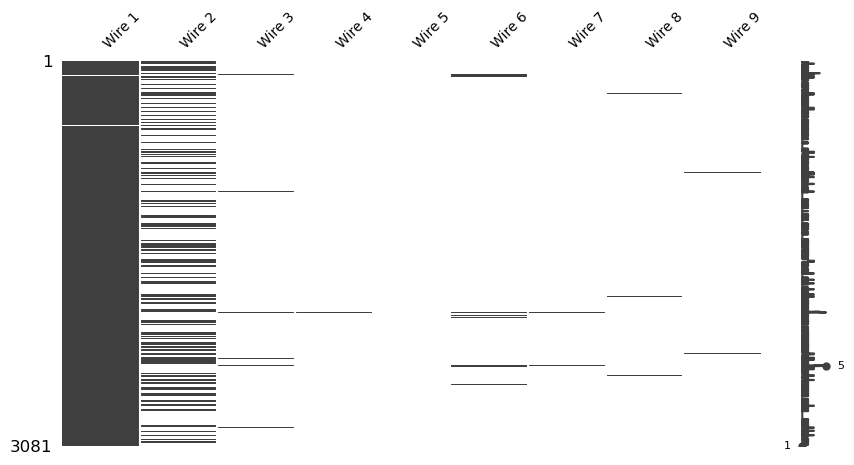

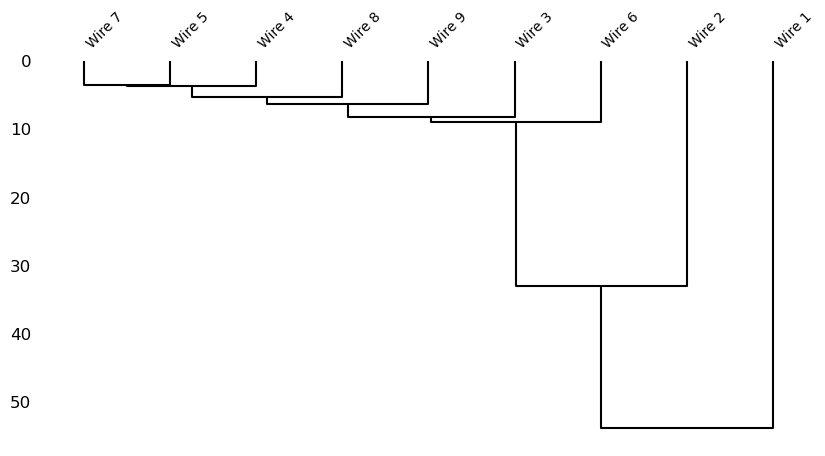

In [41]:
res_analysis(data_wire)
msno.dendrogram(data_wire.iloc[:,1:], figsize=(10, 5), fontsize=10);

Переименование названия столбцов.

In [42]:
data_wire.columns = data_wire.columns.str.lower().str.replace(' ', '_')
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Удаление столбцов с количеством пропусков больше 80%.

In [43]:
data_wire = data_wire[['key', 'wire_1']]
data_wire = data_wire.fillna(0)
print(f'Количество пропусков в таблице:\n{data_wire.isna().sum()}')

Количество пропусков в таблице:
key       0
wire_1    0
dtype: int64


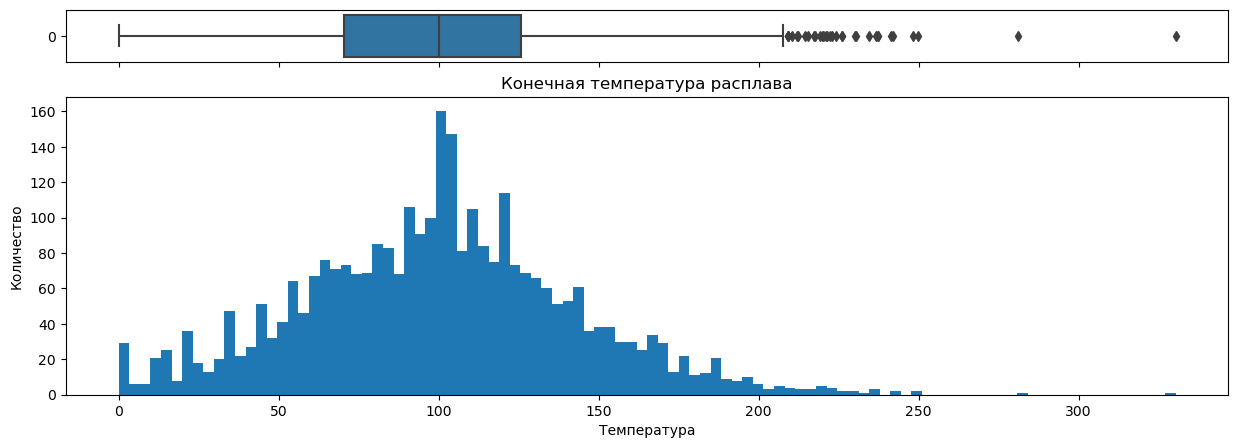

In [44]:
hist_box(
    data=data_wire['wire_1'],
    bins=100, 
    title='Конечная температура расплава',
    xlabel='Температура',
    ylabel='Количество'
)

## 2.7. Файл data_wire_time_new.csv — данные о проволочных материалах (время)

Описательная статистика:


,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3055,1079,63,14,1,73,11,19,29
unique,3055,1079,63,14,1,73,11,19,29
top,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
freq,1,1,1,1,1,1,1,1,1


-----
Информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

-----
Процент наличия данных:



key       100.000000
Wire 1     99.156118
Wire 2     35.021097
Wire 3      2.044791
Wire 4      0.454398
Wire 5      0.032457
Wire 6      2.369361
Wire 7      0.357027
Wire 8      0.616683
Wire 9      0.941253
dtype: float64

-----
Количество явных дубликатов:0
-----
Матрица пропущенных значений:


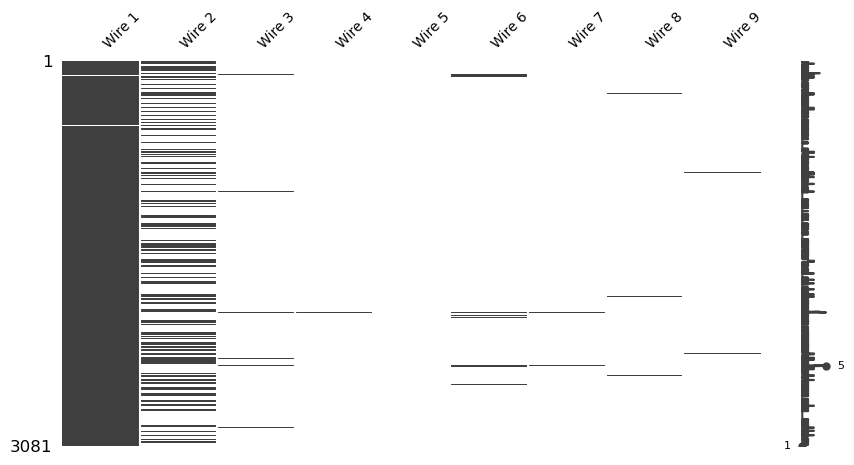

In [45]:
res_analysis(data_wire_time)

Конечная температура расплава не зависит от времени засыпки проволочных материалов, поэтому исключим эти данные из обучения модели.

## 2.8. Вывод по исследовательскому анализу и предобработке данных


#### Файл data_arc_new.csv — данные об электродах

Анализ
1. Явные дубликаты отсутствуют.
2. Пропущенные значения отсутствуют.
3. Активная мощность находится в диапазоне от 0.22 до 1.46, среднее значение 0.66, медиана 0.60. Значения в диапазоне 1.4 - 1.5 рассматриваются как выбросы. Диграмма выглядит, как нормальное распределение, но скошенное вправо.
4. Реактивная мощность имеет минимальное значение -715.48 (аномальное значение, которое после было исключено), максимальное значение 1.27, среднее значение 0.44, медиана 0.44.

Предобработка
1. Переименованы столбцы.
2. Удалены данные партии с отрицательной реактивной мощностью.
3. Произведен расчет полной мощности и добавлен новый столбец.
4. Произведен расчет времени нагрева в секундах и был добавлен.
5. Произведен расчет полной энергии и был добавлен.
6. Объединены данные по номеру партии в сводной таблице с расчетом суммарной энергии, мощностей, времени нагревания.
7. Произведён расчет количества циклов нагрева.
8. Изменены признаки и добавлены:
- 'full_power' - полная мощность;
- 'heating_time' - время нагрева (секунды);
- 'full_energy' - полная энергия;
- 'number_of_heating' количество циклов нагрева каждой партии.

#### Файл data_bulk_new.csv - данные о подаче сыпучих материалов (объём)

Анализ
1. Явные дубликаты отсутствуют.
2. Пропущенные значения присутствуют в каждом столбце, пропуски в столбце 12 связанны с пропусками в стобцах 14 и 15, пропуски в столбце 2 связанны со столбцами 7 и 5. Остальные столбцы практически не связанны.

Предобработка
1. Переименованы столбцы.
2. Удалены признаки, в которых изначально имеется более 80% пропущенных значений, оставшиеся пропущенные значения заполнены нулями. 

#### Файл data_bulk_time_new.csv - данные о подаче сыпучих материалов (время)

Анализ
1. Явные дубликаты отсутствуют.
2. Пропущенные значения присутствуют в каждом столбце, диаграмма схожа с данными о пропусках в данных о подаче сыпучих материалов.

Предобработка
1. Данные содержат информацию о времени засыпки материала и для дальнейшего анализа моут не использоваться.

#### Файл data_gas_new.csv — данные о продувке сплава газом

1. Явные дубликаты отсутствуют.
2. Пропущенные значения отсутствуют.
3. Объем подаваемого газа находится в диапазоне от 0.01 до 78, среднее значение 11, медиана 9.84. Значения от 24 рассматриваются на диаграмме распределения как выбросы.

Предобработка
1. Переименованы столбцы.

#### Файл data_temp_new.csv — результаты измерения температуры

Анализ
1. Явные дубликаты отсутствуют.
2. Пропущены значения в столбце температура.
3. Температура находится в диапазоне от 1191 до 1705, среднее значение 1590.72, медиана 1590.

Предобработка
1. Переименнованны столбцы.
2. Значения с одним замером температуры и ниже среднего значения плавления стали (<1500) удалены.
3. Выполнено определение начальной и конечной температур замеров.

#### Файл data_wire_new.csv — данные о проволочных материалах (объём)

Анализ
1. Явные дубликаты отсутствуют.
2. Пропущенные значения есть в каждом столбце.

Предобработка
1. Удалены признаки, в которых изначально имеется более 80% пропущенных значений.
2. Оставшиеся пропущенные значения заполнены нулями.

#### Файл data_wire_time_new.csv — данные о проволочных материалах (время)

Анализ
1. Явные дубликаты отсутствуют.
2. Пропущенные значения присутствуют в каждом столбце, диаграмма схожа с данными о проволочных материалах.

Предобработка
1. Данные содержат информацию о времени засыпки материала и для дальнейшего анализа моут не использоваться.

# 3. Объединение данных

Объединение данных будет проведено по ключу методом INNER (т.е. берутся только те партии, которые представлены во всех таблицах).

In [46]:
data = data_arc.merge(data_bulk, on='key', how='inner').merge(data_gas, on='key', how='inner'). \
merge(data_temp, on='key', how='inner').merge(data_wire, on='key', how='inner')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2327
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2328 non-null   int64  
 1   active_power       2328 non-null   float64
 2   reactive_power     2328 non-null   float64
 3   full_power         2328 non-null   float64
 4   heating_time       2328 non-null   int64  
 5   full_energy        2328 non-null   float64
 6   number_of_heating  2328 non-null   int64  
 7   bulk_12            2328 non-null   float64
 8   bulk_14            2328 non-null   float64
 9   gas_1              2328 non-null   float64
 10  first_temperture   2328 non-null   float64
 11  last_temperature   2328 non-null   float64
 12  wire_1             2328 non-null   float64
dtypes: float64(10), int64(3)
memory usage: 254.6 KB


In [47]:
data.tail(5)

,key,active_power,reactive_power,full_power,heating_time,full_energy,number_of_heating,bulk_12,bulk_14,gas_1,first_temperture,last_temperature,wire_1
2323,2495,3.168133,2.210936,3.868721,723,694.177326,4,256.0,129.0,7.125735,1570.0,1591.0,89.150879
2324,2496,4.174918,2.872031,5.070316,940,815.818538,6,256.0,129.0,9.412616,1554.0,1591.0,114.179527
2325,2497,3.605239,2.452092,4.360918,569,823.020520,3,230.0,124.0,6.271699,1571.0,1589.0,94.086723
2326,2498,3.202310,2.239820,3.909917,750,581.810739,5,206.0,129.0,14.953657,1591.0,1594.0,118.110717
2327,2499,1.737084,1.296836,2.169252,883,532.386183,4,233.0,126.0,11.336151,1569.0,1603.0,110.160958


## 3.1. Вывод по объединению таблиц

1. Данные объединены методом INNER.
2. Пропуски в данных отсутствуют.
3. Типы данных соответствуют содержанию.
4. Максимальная партия с ключем 2499.

# 4. Исследовательский анализ и предобработка данных объединённого датафрейма

## 4.1. Исследование распределения признаков

Перевод столбца 'key' в индекс.

In [48]:
data.set_index('key', inplace = True)
data.head()

,active_power,reactive_power,full_power,heating_time,full_energy,number_of_heating,bulk_12,bulk_14,gas_1,first_temperture,last_temperature,wire_1
key,,,,,,,,,,,,
1,3.036730,2.142821,3.718736,1098,770.282114,5,206.0,150.0,29.749986,1571.0,1613.0,60.059998
2,2.139408,1.453357,2.588349,811,481.760005,4,206.0,149.0,12.555561,1581.0,1602.0,96.052315
3,4.063641,2.937457,5.019223,655,722.837668,5,205.0,152.0,28.554793,1596.0,1599.0,91.160157
4,2.706489,2.056992,3.400038,741,683.455597,4,207.0,153.0,18.841219,1601.0,1625.0,89.063515
5,2.252950,1.687991,2.816980,869,512.169934,4,203.0,151.0,5.413692,1576.0,1602.0,89.238236


Построение гистограммы итогового датасета.

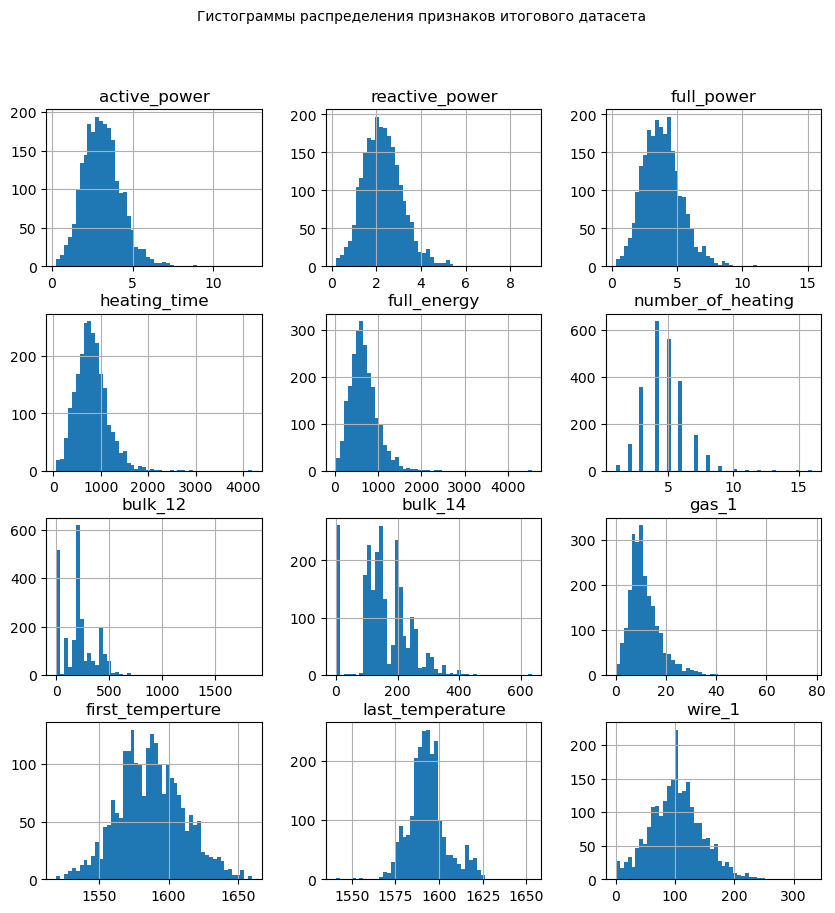

In [49]:
data.hist(figsize=(10, 10), bins=50)
plt.suptitle('Гистограммы распределения признаков итогового датасета', fontsize=10);

### 4.1.1. Вывод по распределению признаков

- Большая часть данных имеет нормальное распределение.
- В данных имеются выбросы.
- Необходимо проверить корреляцию данных и их вличние на целевой признак `last_temperature`.

## 4.2. Корреляция данных

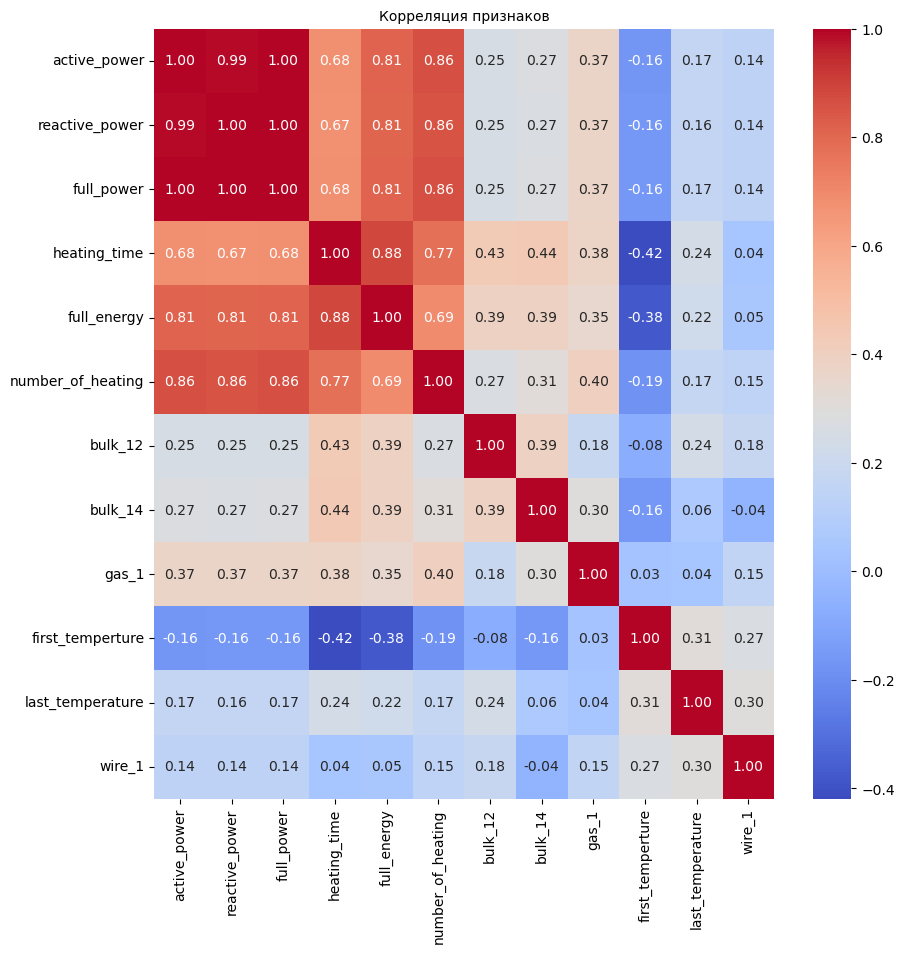

In [50]:
plt.figure(figsize=(10, 10))
plt.title('Корреляция признаков', fontsize=10)
sns.heatmap(data.corr(method='spearman'), annot = True, cmap='coolwarm', fmt ='.2f')
plt.show();

Присутствуют показатели с мультиколлинеарностью, необходимо избавиться от них.

Максимально коррелируют с целевым признаком 'last_temperature':

- первичная температура 'first_temperature';
- проволока 'wire_1'
- время нагрева 'heating_time';
- добавка 'bulk_12';
- полная энергия 'full_energy';
- активная мощность 'active_power';
- полная мощность 'full_power';
- количество циклов нагрева 'number_of_heating'.

Удаление лишних столбцов, для которых коэффициент корреляции больше 0,9.

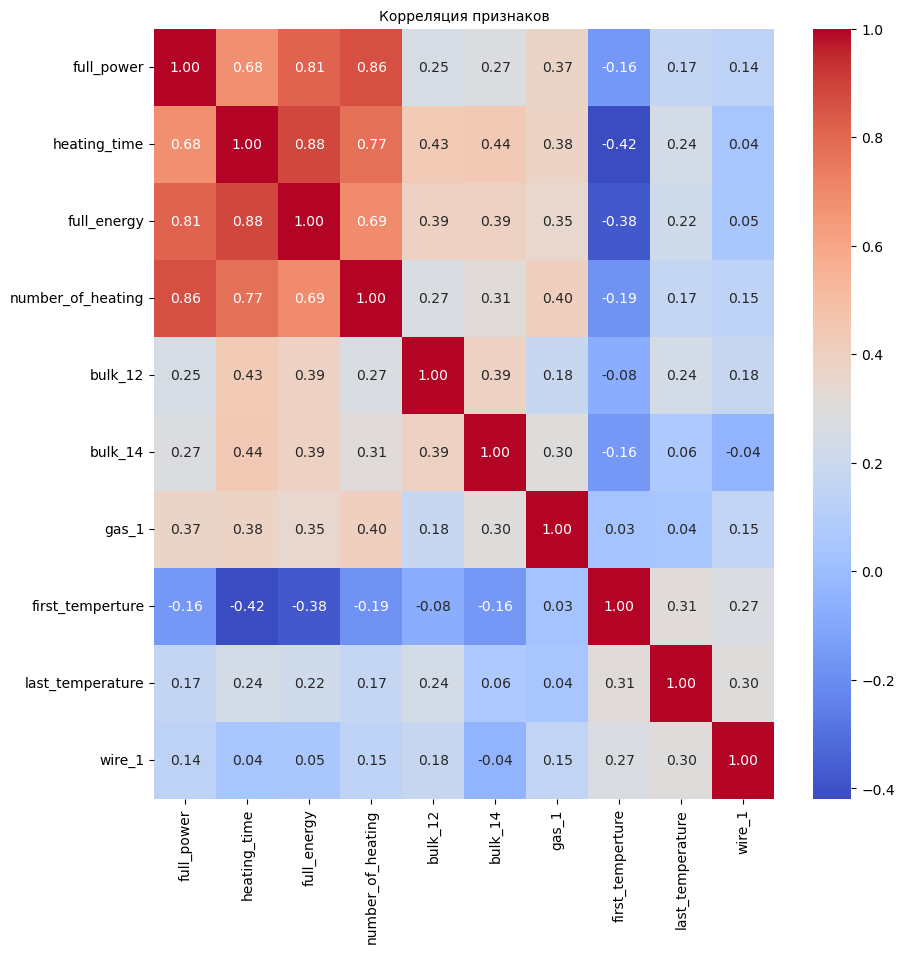

In [51]:
data = data.drop(['active_power', 'reactive_power'], axis=1)

plt.figure(figsize=(10, 10))
plt.title('Корреляция признаков', fontsize=10)
sns.heatmap(data.corr(method='spearman'), annot = True, cmap='coolwarm', fmt ='.2f')
plt.show();

## 4.3. Вывод по анализу и предобработке данных объединённого датафрейма

- Номер ключа переведен в индекс.
- Данные распределены в основном нормально.
- В данных присутствуют выбросы.
- Удалены столбцы с мультиколлинеарностью.

#  5. Подготовка данных

Разделение данных в соотношении 75 : 25.

In [52]:
X = data.drop('last_temperature', axis=1)
y = data['last_temperature']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25, 
    random_state=RANDOM_STATE
)

print(f'Соотношение {X_train.shape[0] / X.shape[0]} : {X_test.shape[0] / X.shape[0]}') 

Соотношение 0.75 : 0.25


Пайплайн для удобства подготовки данных:

In [53]:
num_columns = X.columns.tolist()

In [54]:
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns)
    ]
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression()
    )
])

# 6. Обучение моделей и выбор лучшей

## 6.1. Обучение моделей

In [55]:
param_grid = [
    
    {
        'models': [LinearRegression()],  
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [LGBMRegressor(verbose=-1, random_state=RANDOM_STATE)],
        'models__max_depth': [2, 5, 8, 10, 12],
        'models__num_leaves': [2, 3, 5, 7, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [CatBoostRegressor(iterations=200,
                                     verbose=False,
                                     random_state = RANDOM_STATE)],
        'models__depth': [3, 5, 7],
        'models__learning_rate': [0.01, 0.1, 0.5],
        'models__l2_leaf_reg': [1, 3, 5, 7, 9],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [56]:
randomized_search = RandomizedSearchCV(pipe_final,
                                       param_grid,
                                       cv=5,
                                       n_iter=5,
                                       scoring='neg_mean_absolute_error',
                                       random_state=RANDOM_STATE,
                                       n_jobs=-1
).fit(X_train, y_train)

In [57]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', -randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['full_power', 'heating_time',
                                                   'full_energy',
                                                   'number_of_heating',
                                                   'bulk_12', 'bulk_14',
                                                   'gas_1', 'first_temperture',
                                                   'wire_1'])])),
                ('models',
                 <catboost.core.CatBoostRegressor object at 0x000002360A26A950>)])
Метрика лучшей модели на кросс-валидации: 6.487181153380004


## 6.2. Проверка лучшей модели на тестовой выборке

In [58]:
best_model = randomized_search.best_estimator_
best_model_preprocessor = randomized_search.best_estimator_['preprocessor']
randomized_search.best_params_

{'preprocessor__num': MinMaxScaler(),
 'models__learning_rate': 0.1,
 'models__l2_leaf_reg': 3,
 'models__depth': 3,
 'models': <catboost.core.CatBoostRegressor at 0x2360a4fa610>}

In [59]:
predict_test = best_model.predict(X_test)
MAE_score = mean_absolute_error(y_test, predict_test)

print(f'MAE на тестовой выборке: {MAE_score:.2f}')

MAE на тестовой выборке: 6.50


## 6.3. Расчет метрики r2 на тестовой выборке

In [60]:
r2 = r2_score(y_test, predict_test)

print(f'r2 на тестовой выборке: {r2:.2f}')

r2 на тестовой выборке: 0.30


Данное значение r2 показывает, что прогноз модели лучше, чем среднеее арифметическое фактических целевых значений, но модель будет вести себя не идеально с неизвестным набором данных.

## 6.4. Cравнение с константной моделью DummyRegressor

In [61]:
constant_model = DummyRegressor(strategy='median')
constant_model.fit(X_train, y_train)
constant_predict_test = constant_model.predict(X_test)
constant_MAE_score = mean_absolute_error(y_test, constant_predict_test)

print(f'MAE констатной модели на тестовой выборке: {constant_MAE_score:.2f}')

MAE констатной модели на тестовой выборке: 7.74


Метрика CatBoostRegressor лучше, чем на константной модели DummyRegressor.

## 6.5. Оценка важности признаков у лучшей модели

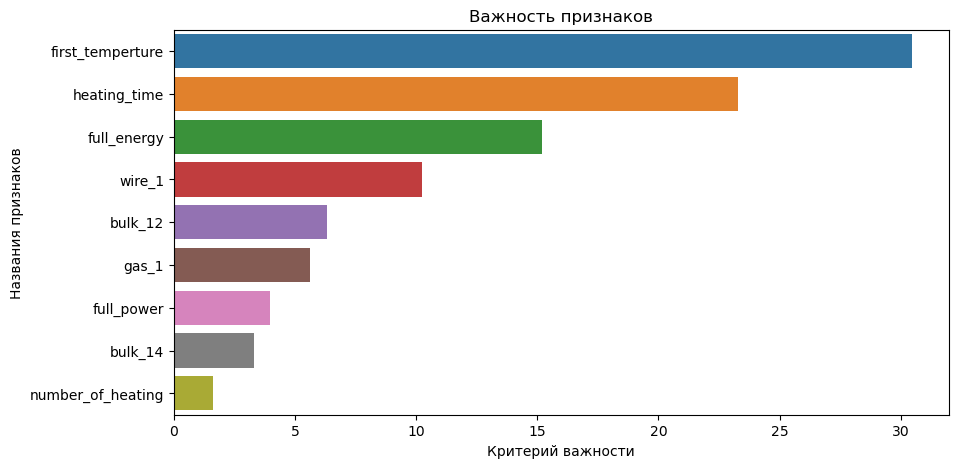

In [62]:
plt.figure(figsize=(10,5))

plot_data = pd.Series(randomized_search
                      .best_estimator_
                      ._final_estimator
                      .feature_importances_,
                      index=X_test
                      .columns).sort_values(ascending=False)

sns.barplot(x=plot_data, y=plot_data.index)

plt.title('Важность признаков')
plt.xlabel('Критерий важности')
plt.ylabel('Названия признаков')
plt.show()

### 6.5.1. Вывод по важности признаков:

- Наиболее важными признаками являются первичная температура и время нагрева.
- Наименее значимый признак - количество циклов нагрева.

## 6.6. Вывод по обучению моделей

1. Для обучения и оценки моделей данные были разбиты в следующих проворциях: кросс-валидация 75%, тест 25 %.
2. Использовались модели LinearRegression, LGBMRegressor и CatBoostRegressor.
3. Лучшей моделью по итогам кросс-валидиации является CatBoostRegressor.
4. Метрика лучшей модели на кросс-валидации: МАЕ = 6.49.
5. Параметры лучшей модели: {'preprocessor__num': MinMaxScaler(), 'models__learning_rate': 0.1, 'models__l2_leaf_reg': 3, 'models__depth': 3, 'models': <catboost.core.CatBoostRegressor at 0x2175f96b550>}.
6. Метрика лучшей модели на тестовой выборке MAE = 6.50, что соответствует требованиям заказчика.
7. Метрика r2 на тестовой выборке равна 0.30, данное значение r2 показывает, что прогноз модели лучше, чем среднеее арифметическое фактических целевых значений, но модель будет вести себя не идеально с неизвестным набором данных.
8. MAE констатной модели DummyRegressor на тестовой выборке: 7.74, что хуже CatBoostRegressor.
9. Наиболее важным признаками являются первичная температура и время нагрева. Наименее значимый признак - количество циклов нагрева.

# 7. Общий вывод и рекомендации заказчику

Целью данного проекта являлась оптимизация производственных расходов металлургического комбината, с помощью построения модели машинного обучения, которая предсказывает температуру сплава.

Данная модель позволит снизить затраты на электричество, обслуживание и ремонты.

- Целевая переменная target - последняя температура по всей партии 
- Целевая метрика - MAE (нужно получить не более 6.8 на тесте)


Для решения данной задачи заказчиком было предоставлено семь файлов:

- data_arc_new.csv — данные об электродах;

- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);

- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);

- data_gas_new.csv — данные о продувке сплава газом;

- data_temp_new.csv — результаты измерения температуры;

- data_wire_new.csv — данные о проволочных материалах (объём);

- data_wire_time_new.csv — данные о проволочных материалах (время).


После загрузки данных, был произведен исследовательский анализ данных.

Для дальнейшего анализа и предобработи рассмотренно 5 таблиц:

1. Файл data_arc_new.csv — данные об электродах

    1. Переименованы столбцы.
    2. Удалены данные партии с отрицательной реактивной мощностью.
    3. Произведен расчет полной мощности и добавлен новый столбец.
    4. Произведен расчет времени нагрева в секундах и был добавлен столбец.
    5. Произведен расчет полной энергии и был добавлен столбец.
    6. Объединены данные по номеру партии в сводной таблице с расчетом суммарной энергии, мощностей, времени нагревания.
    7. Произведён расчет количества циклов нагрева.
    8. Изменены признаки и добавлены:
        - 'full_power' - полная мощность;
        - 'heating_time' - время нагрева (секунды);
        - 'full_energy' - полная энергия;
        - 'number_of_heating' количество циклов нагрева каждой партии.

2. Файл data_bulk_new.csv - данные о подаче сыпучих материалов (объём)

    1. Переименованы столбцы.
    2. Удалены признаки, в которых изначально имеется более 80% пропущенных значений, оставшиеся пропущенные значения заполнены нулями, во всех столбцах, кроме bulk_12, bulk_14.

3. Файл data_gas_new.csv — данные о продувке сплава газом

    1. Переименованы столбцы.
    2. Дополнительные преобразования не требуются, анализ выбросов произведен после создания тренировочной выборки.

4. Файл data_temp_new.csv — результаты измерения температуры

    1. Переименнованны столбцы.
    2. Значения с одним замером температуры и ниже среднего значения плавления стали (<1500) удалены.
    3. Выполнено определение начальной и конечной температур замеров.

5. Файл data_wire_new.csv — данные о проволочных материалах (объём)

    1. Переименованы столбцы.
    2. Удалены признаки, в которых изначально имеется более 80% пропущенных значений.
    3. Оставшиеся пропущенные значения заполнены нулями, кроме wire_1.

Предобработанные данные датасетов были объединены по ключу 'key' методом INNER.

Максимально коррелируют с целевым признаком 'last_temperature':

- первичная температура 'first_temperature';
- проволока 'wire_1'
- время нагрева 'heating_time';
- добавка 'bulk_12';
- полная энергия 'full_energy';
- активная мощность 'active_power';
- полная мощность 'full_power';
- количество циклов нагрева 'number_of_heating'.

Обучение моделей:

Признаки моделей: 'full_power', 'heating_time', 'full_energy', 'number_of_heating', 'bulk_12', 'bulk_14', 'gas_1', 'first_temperture', 'wire_1'.

1. Для обучения и оценки моделей данные были разбиты в следующих проворциях: кросс-валидация 75%, тест 25 %.
2. Использовались модели LinearRegression, LGBMRegressor и CatBoostRegressor.
3. Лучшей моделью по итогам кросс-валидиации является CatBoostRegressor.
4. Метрика лучшей модели на кросс-валидации: МАЕ = 6.49.
5. Параметры лучшей модели: {'preprocessor__num': MinMaxScaler(), 'models__learning_rate': 0.1, 'models__l2_leaf_reg': 3, 'models__depth': 3, 'models': <catboost.core.CatBoostRegressor at 0x2175f96b550>}.
6. Метрика лучшей модели на тестовой выборке MAE = 6.50, что соответствует требованиям заказчика.
7. Метрика r2 на тестовой выборке равна 0.30, данное значение r2 показывает, что прогноз модели лучше, чем среднеее арифметическое фактических целевых значений, но модель будет вести себя не идеально с неизвестным набором данных.
8. MAE констатной модели DummyRegressor на тестовой выборке: 7.74, что хуже CatBoostRegressor.
9. Наиболее важным признаками являются первичная температура и время нагрева. Наименее значимый признак - количество циклов нагрева.


#### Рекомендации заказчику

Улучшить решение задачи поможет: Возможно улучшение модели и предсказывание новых данных при помощи исключения аномальных значений признаков в объединенном датасете.